<a href="https://colab.research.google.com/github/HarshPancholi2002/Untitled24/blob/main/Weather_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing ARIMA model - an ARMA model fitted on the n-th order differenced time series such that the final differenced time series is stationary. 

In [ ]:
!pip install pmdarima --q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 67.4 MB/s eta 0:00:00


Importing libraries

In [ ]:
# Magic function that will make your plot outputs appear and be stored within the notebook
%matplotlib inline

# Function used to to render higher resolution images
%config InlineBackend.figure_format = 'retina'

# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

# Reproducibility
import random

# Data manipulation
import os
import pandas as pd
import numpy as np
from datetime import datetime, date 

pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno 

# Standardizing the style for the visualizations 
sns.set_theme()
sns.set_palette("pastel")
plt.style.use('seaborn-ticks')

# Machine learning models and utilities 
from sklearn.metrics import mean_absolute_error, mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
import pmdarima as pm
from prophet import Prophet
import math
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

SEEDING the notebook to obtain same results with the same SEED value

In [ ]:
# Seed value for reproducibility
SEED = 42

In [ ]:
# Seeding all the notebook for reproducibility purposes
def seed_it(SEED):
    
    np.random.seed(SEED)
    random.seed(SEED)

    print('Notebook has been seeded successfully')

In [ ]:
# Seeding notebook
seed_it(SEED)

Notebook has been seeded successfully


Importing and reading the Dataset

In [ ]:
# Training path 
train= "DailyDelhiClimateTrain.csv"
df=pd.read_csv(train)

In [ ]:
# Dataset sneak-peek
df.head(3).append(df.tail(3))

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000
1461,2017-01-01,10.000000,100.000000,0.000000,1016.000000


In [ ]:
# Dataset length
print('The total number of rows in the dataset is: ',len(df))

The total number of rows in the dataset is:  1462


In [ ]:
 #Date original data type
type(df['date'][0])

str

Converting the str -- Timestamp for better model tuning

In [ ]:
# Transforming date(str) to Timestamp format
df['date'] =pd.to_datetime(df['date'], format = '%Y/%m/%d')
type(df['date'][0])

pandas._libs.tslibs.timestamps.Timestamp

Before moving to Time series data analysis, checking the dataset for any missing values

In [ ]:
# Table showing the number of missing values and percentage 
# of missing values in the current dataset
dict = {}
for i in list(df.columns):
    dict[i] = (df[i].isnull().sum(),round(df[i].isnull().sum()/len(df)*100,2))
 
pd.DataFrame(dict,index=["# of missing values","% of missing values"]).transpose().sort_values(by=["# of missing values"], ascending=False)

,# of missing values,% of missing values
date,0.0,0.0
meantemp,0.0,0.0
humidity,0.0,0.0
wind_speed,0.0,0.0
meanpressure,0.0,0.0


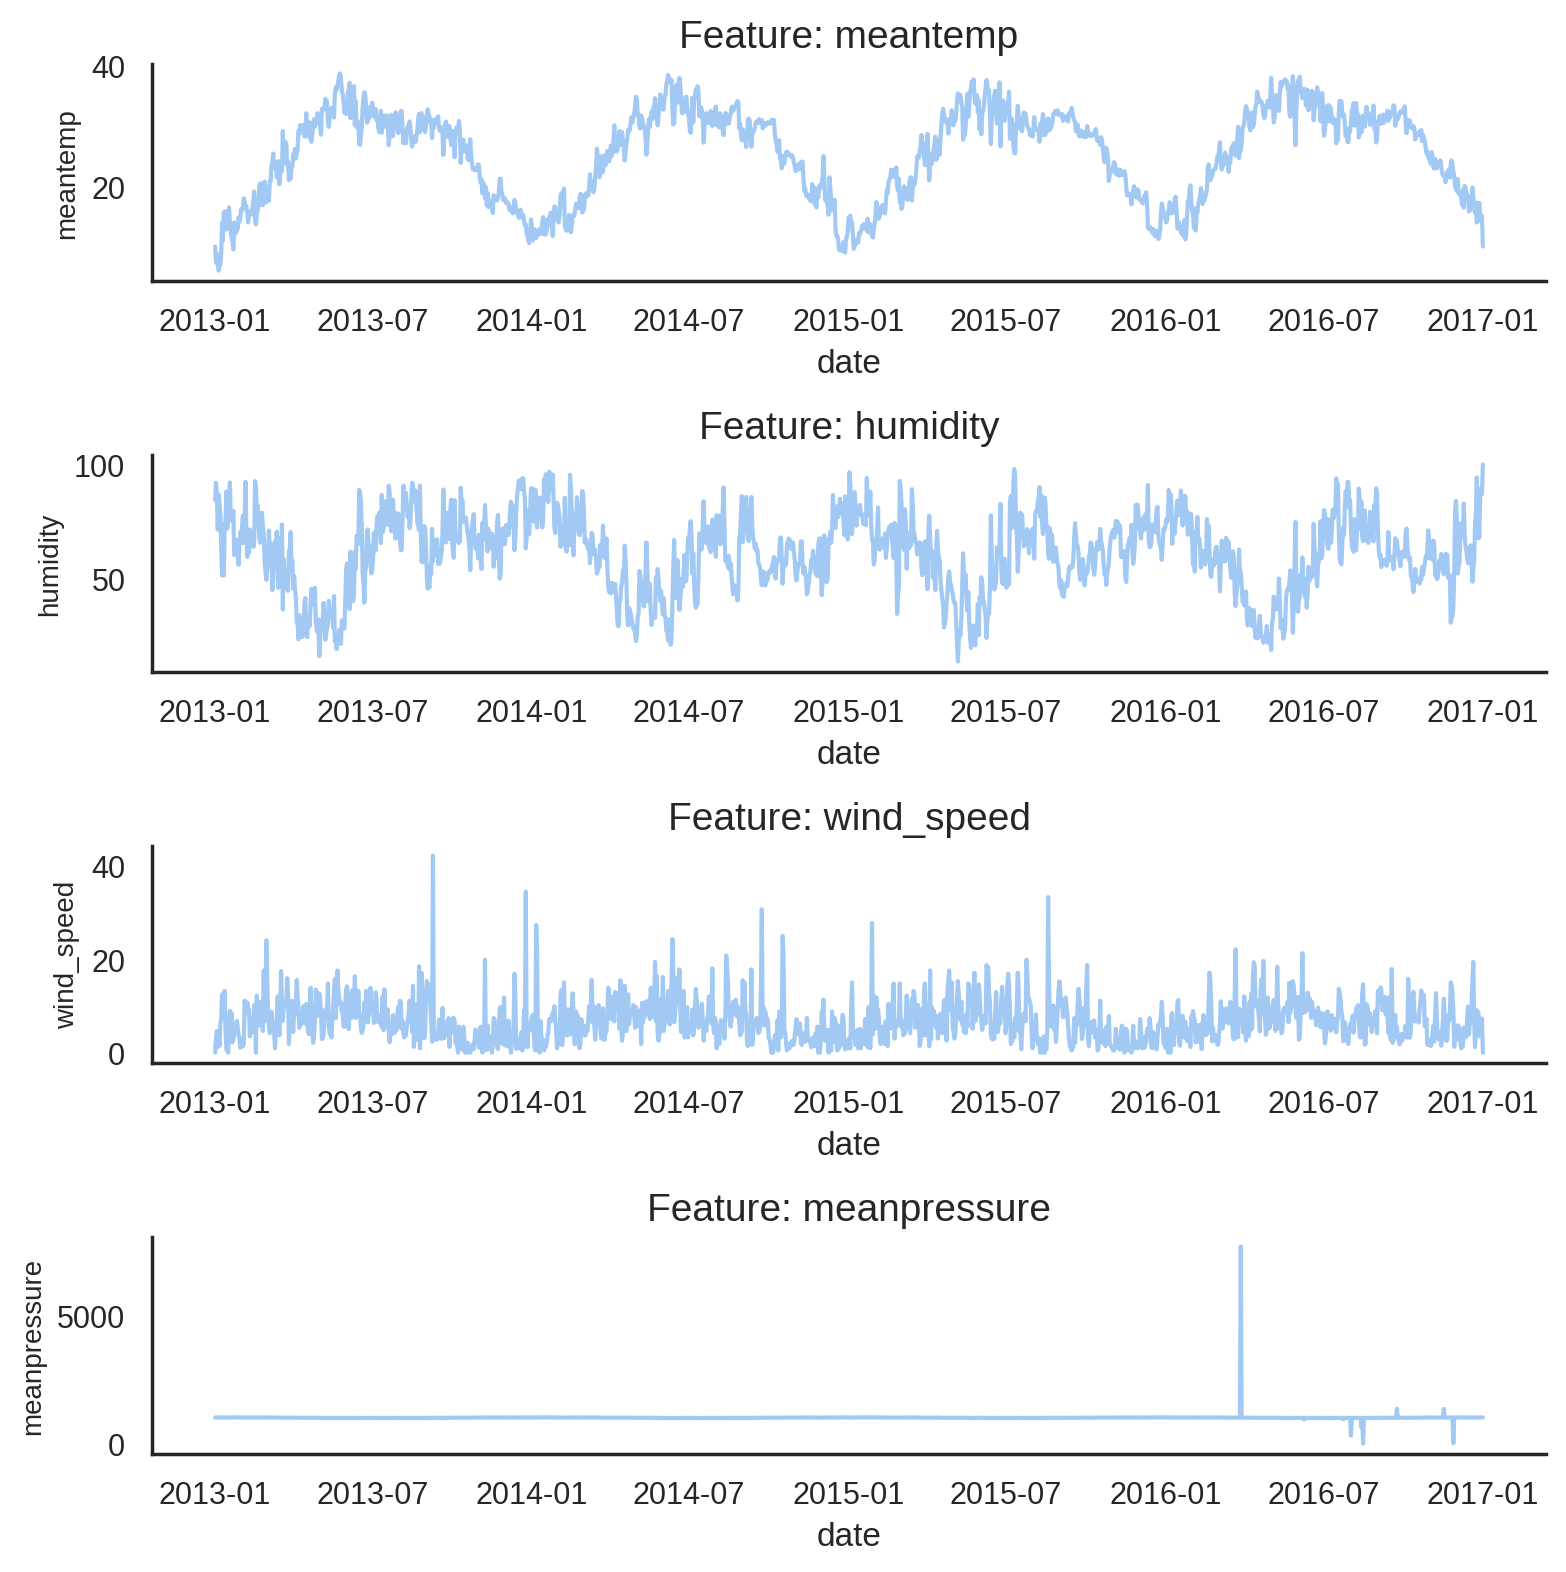

In [ ]:
# Plotting each of the time series 
fig, ax =plt.subplots(nrows=4,ncols=1,figsize=(8,8)) 
sns.despine()

for i, column in enumerate(df.drop('date', axis=1).columns):
    sns.lineplot(x=df['date'], y=df[column], ax=ax[i])
    ax[i].set_title('Feature: {}'.format(column), fontsize=14)
    ax[i].set_ylabel(ylabel=column, fontsize=10)
    
plt.tight_layout()

We seem to have some unusual readings after looking at the meanpressure graph. We will develop a function that temporarily removes outliers in order to get a better visualisation.

Our time series appears to be stationary, with little volatility and a consistent trend, with the exception of the meanpressure outliers.

In [ ]:
# Function for outlier removal
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

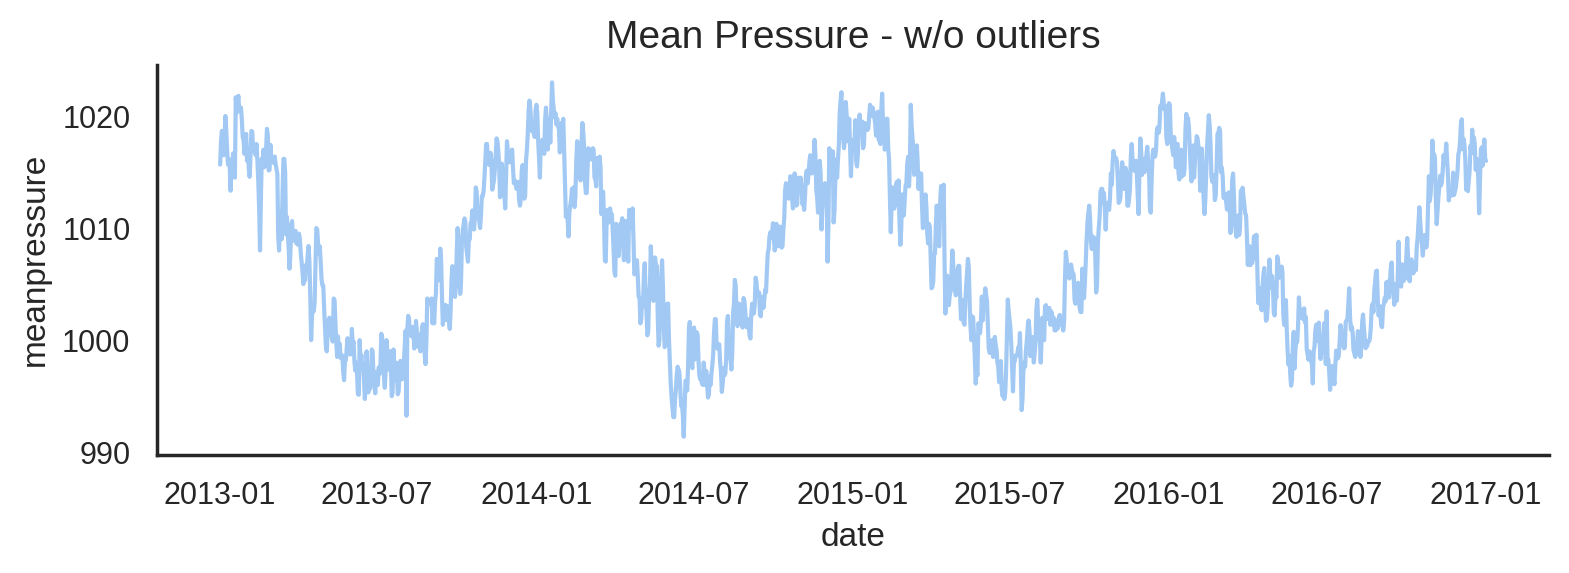

In [ ]:
# Applying remove_outlier fuction to meanpressure feature
mean_pre= remove_outlier(df, 'meanpressure')

# Plotting meaenpressure w/o outliers for a better visualization 
fig, ax =plt.subplots(figsize=(8,3)) 
sns.despine()
ax.set_title('Mean Pressure - w/o outliers', size=14)
sns.lineplot(data=mean_pre,x='date',y='meanpressure')

plt.tight_layout()

In order to ensure that our data is reliable, we must replace the incorrect measurements (outliers). Interpolation is one of the method for achieving this.

In [ ]:
# Replacing outliers with NaN values 
def replace_outliers(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    
    df_in.loc[(df[col_name]<q1-1.5*iqr) | (df[col_name]>q3 + 1.5*iqr),col_name] = np.nan
    
    return df_in

In [ ]:
# Applying replace_outliers function to meanpressure 
df = replace_outliers(df,'meanpressure' ) 

In [ ]:
# Quantifying how many NaN value we have after replace_outliers was applied
print('Total NaN values for meanpressure',df['meanpressure'].isnull().sum())

Total NaN values for meanpressure 9


In [ ]:
# Interpolating meanpressure NaN values 
df['meanpressure'] = df['meanpressure'].interpolate()

In [ ]:
# meanpressure NaN values after interpolation 
print('Total NaN values for meanpressure',df['meanpressure'].isnull().sum())

Total NaN values for meanpressure 0


Downsampling the dataset for getting smooth curve in the results to aid better visualization.

In [ ]:
# Downsampling dataset Days -> Week 
downsample = df[['date',
                 'meantemp', 
                 'humidity',
                 'wind_speed', 
                 'meanpressure'
                ]].resample('7D', on='date').mean().reset_index(drop=False)

df = downsample.copy()

In [ ]:
# Number of rows of the dataset adter downsampling
print('The total number of rows dataset after downsampling: ',len(df))

The total number of rows dataset after downsampling:  209


To perform a univariate forecast, Augmented Dickey-Fuller(ADF) test is used to measure the stationarity.

In order to run the ADF test, we build a function that makes it possible to see the outcomes:

Our ADF statistic is less than 1% of the critical value, as shown by a green curve (the time series is stationary).

Our ADF statistic is over 1% of the crucial value but below 5% of the critical value, as shown by a blue curve (the time series is stationary).

A red curve indicates that we need to perform adjustments to make our time series stationary because our ADF statistic is above 5% of the required value.


In [ ]:
# Function to visualize Augmented Dickey–Fuller test
def visualize_adfuller_results(series, title, ax):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen' 
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'orange'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'red'
    else:
        linecolor = 'purple'
    sns.lineplot(x=df['date'], y=series, ax=ax, color=linecolor)
    ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)

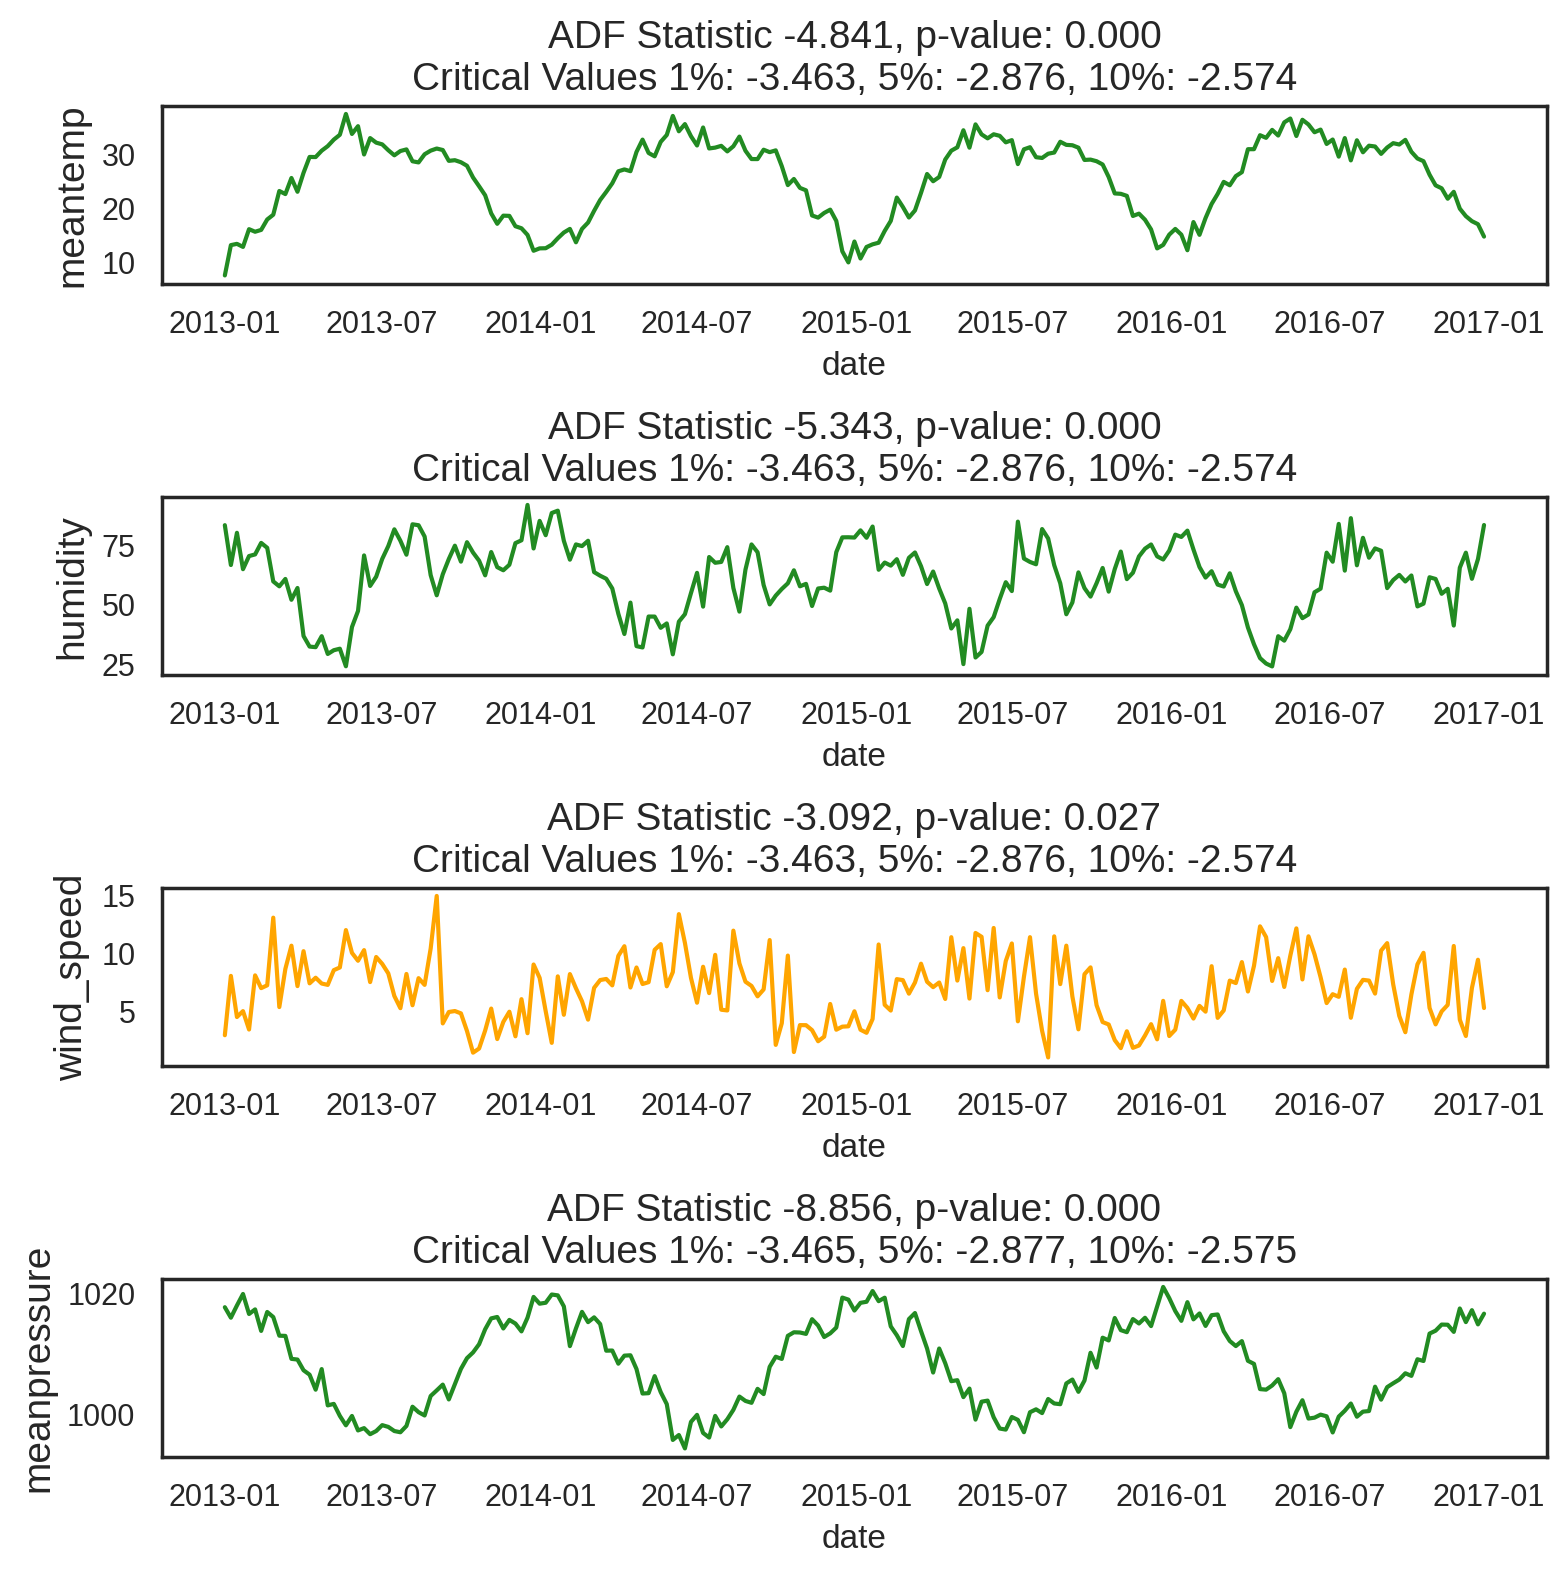

In [ ]:
# Plotting Augmented Dickey–Fuller test results for each column
fig, ax =plt.subplots(nrows=4,ncols=1,figsize=(8,8))

visualize_adfuller_results(df['meantemp'].values, 'meantemp', ax[0])
visualize_adfuller_results(df['humidity'].values, 'humidity', ax[1])
visualize_adfuller_results(df['wind_speed'].values, 'wind_speed', ax[2])
visualize_adfuller_results(df['meanpressure'].values, 'meanpressure', ax[3])

plt.tight_layout()

It seems that all of our time series are stationary and can be supplied directly to the ARIMA model without needing to be converted.

In order to acquire a more thorough understanding, we will now decompose our time series.


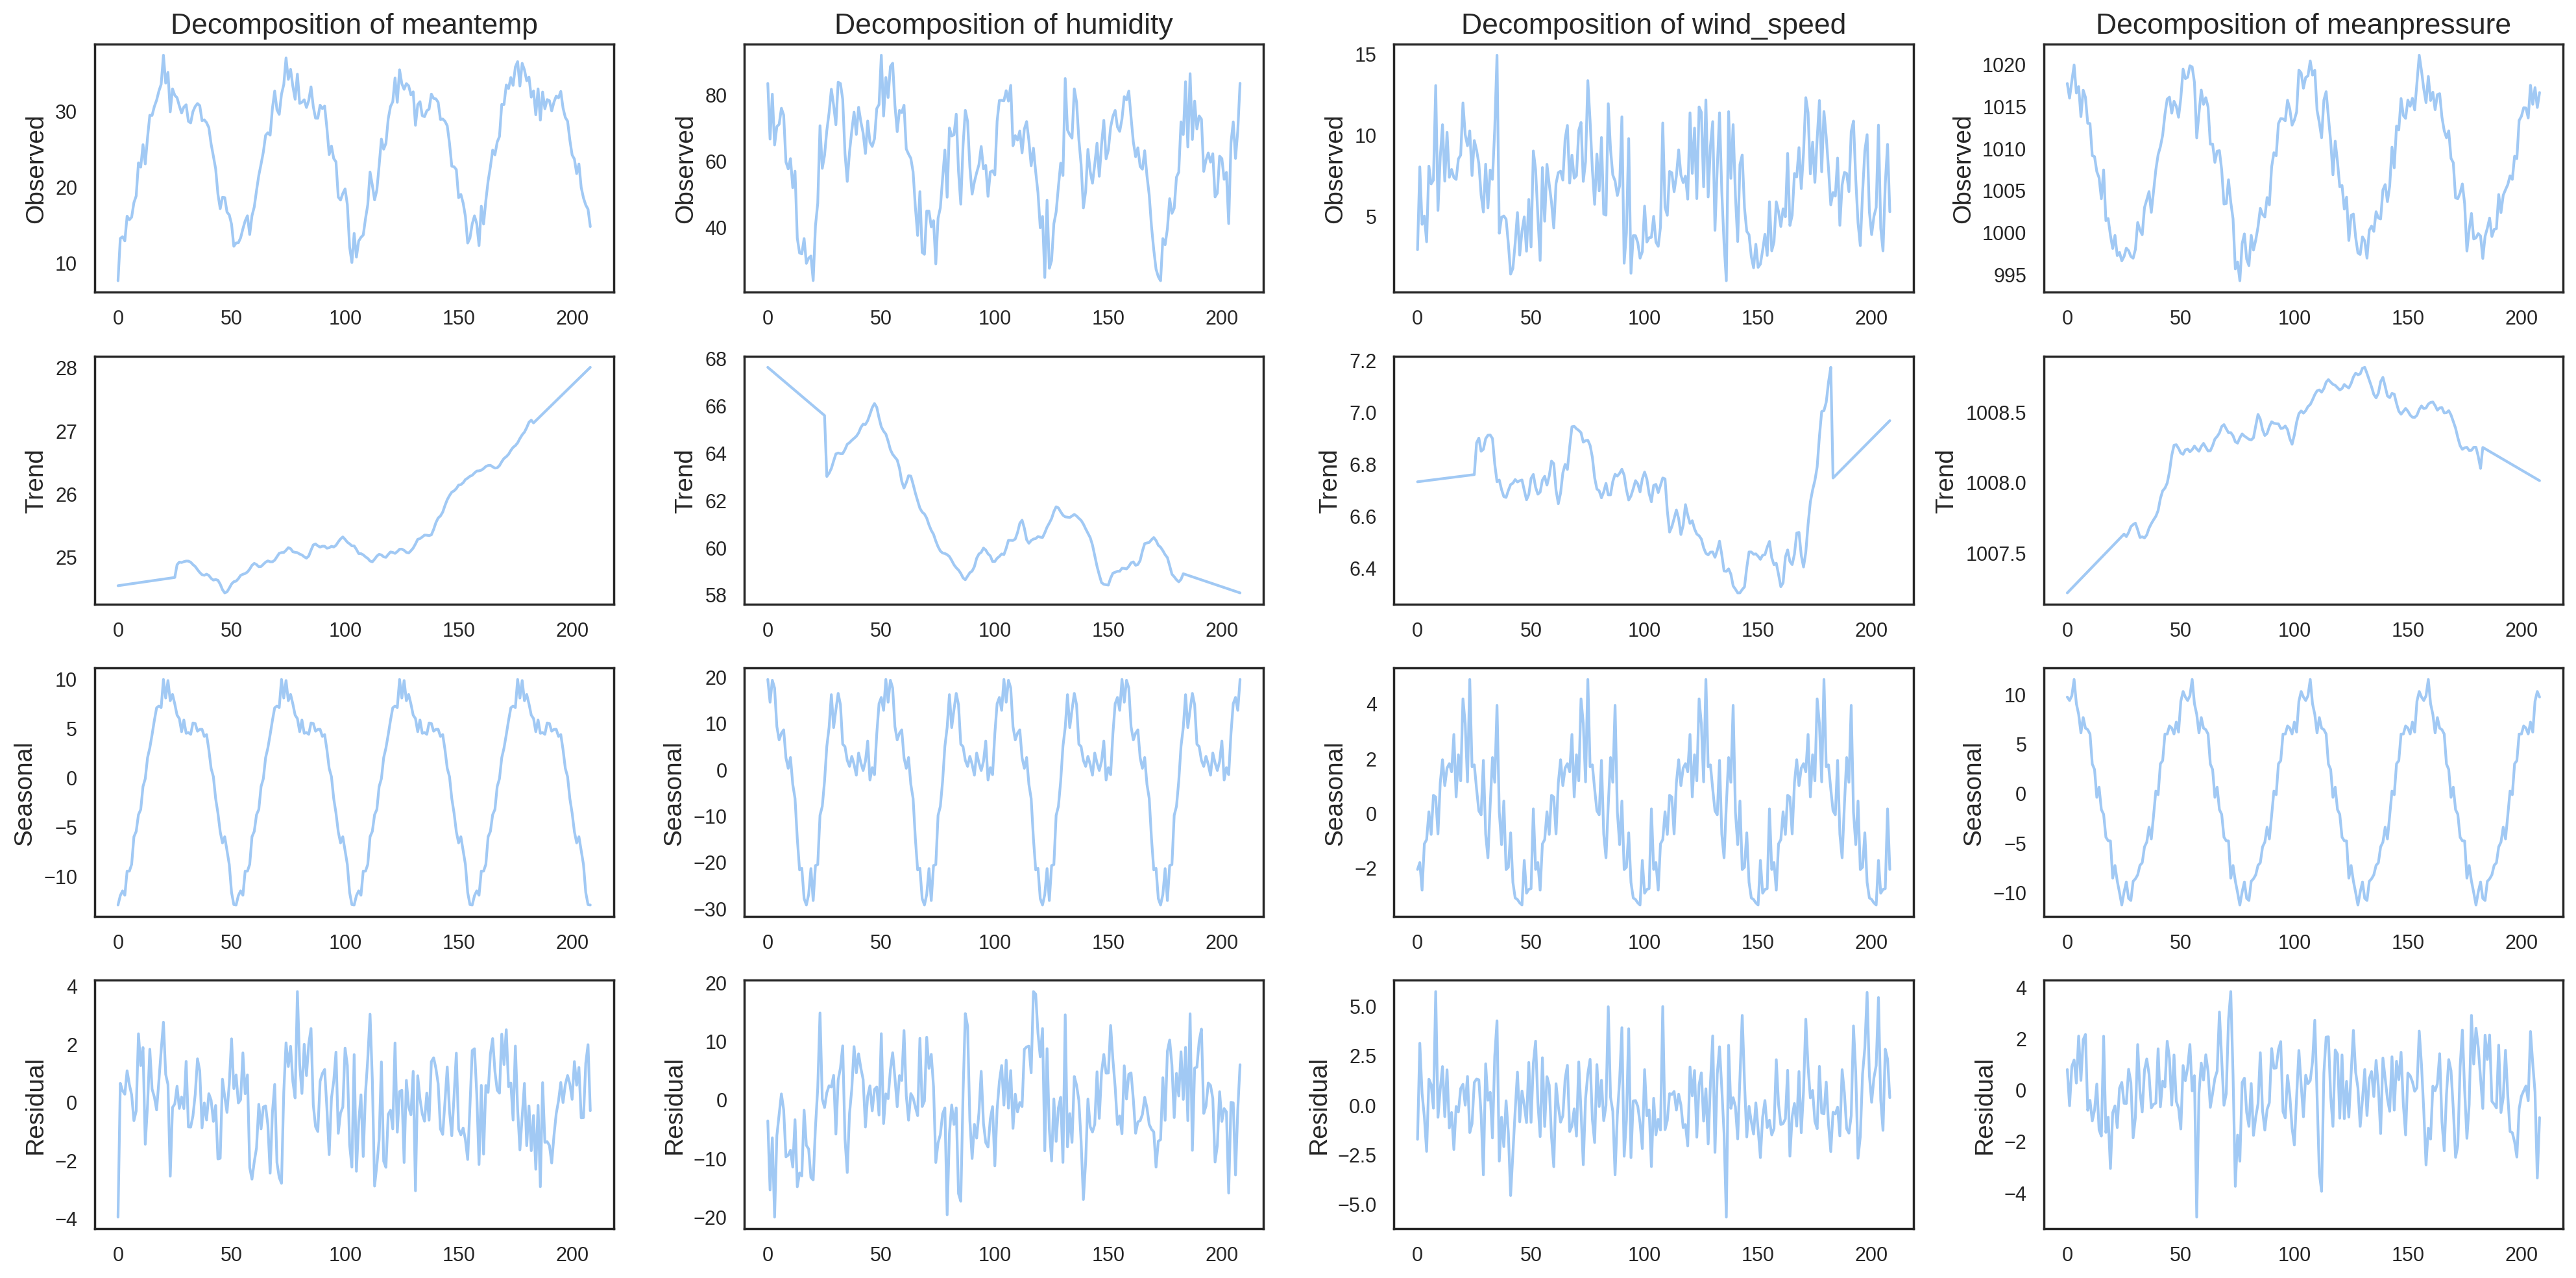

In [ ]:
# Decomposing time series 
columns=['meantemp','humidity','wind_speed','meanpressure']

fig, ax =plt.subplots(nrows=4,ncols=4,figsize=(20,10))

for i, column in enumerate(columns):
    
    res = seasonal_decompose(df[column], period=52, model='additive', extrapolate_trend='freq')
    
    ax[0,i].set_title('Decomposition of {}'.format(column), fontsize=16)
    res.observed.plot(ax=ax[0,i], legend=False)
    ax[0,i].set_ylabel('Observed', fontsize=14)

    res.trend.plot(ax=ax[1,i], legend=False)
    ax[1,i].set_ylabel('Trend', fontsize=14)

    res.seasonal.plot(ax=ax[2,i], legend=False)
    ax[2,i].set_ylabel('Seasonal', fontsize=14)
    
    res.resid.plot(ax=ax[3,i], legend=False)
    ax[3,i].set_ylabel('Residual', fontsize=14)
    
plt.tight_layout()

We can see that while seasonality is apparent across all features, trends exhibit very little change across all features.

Let's examine each column's seasonality in more detail.


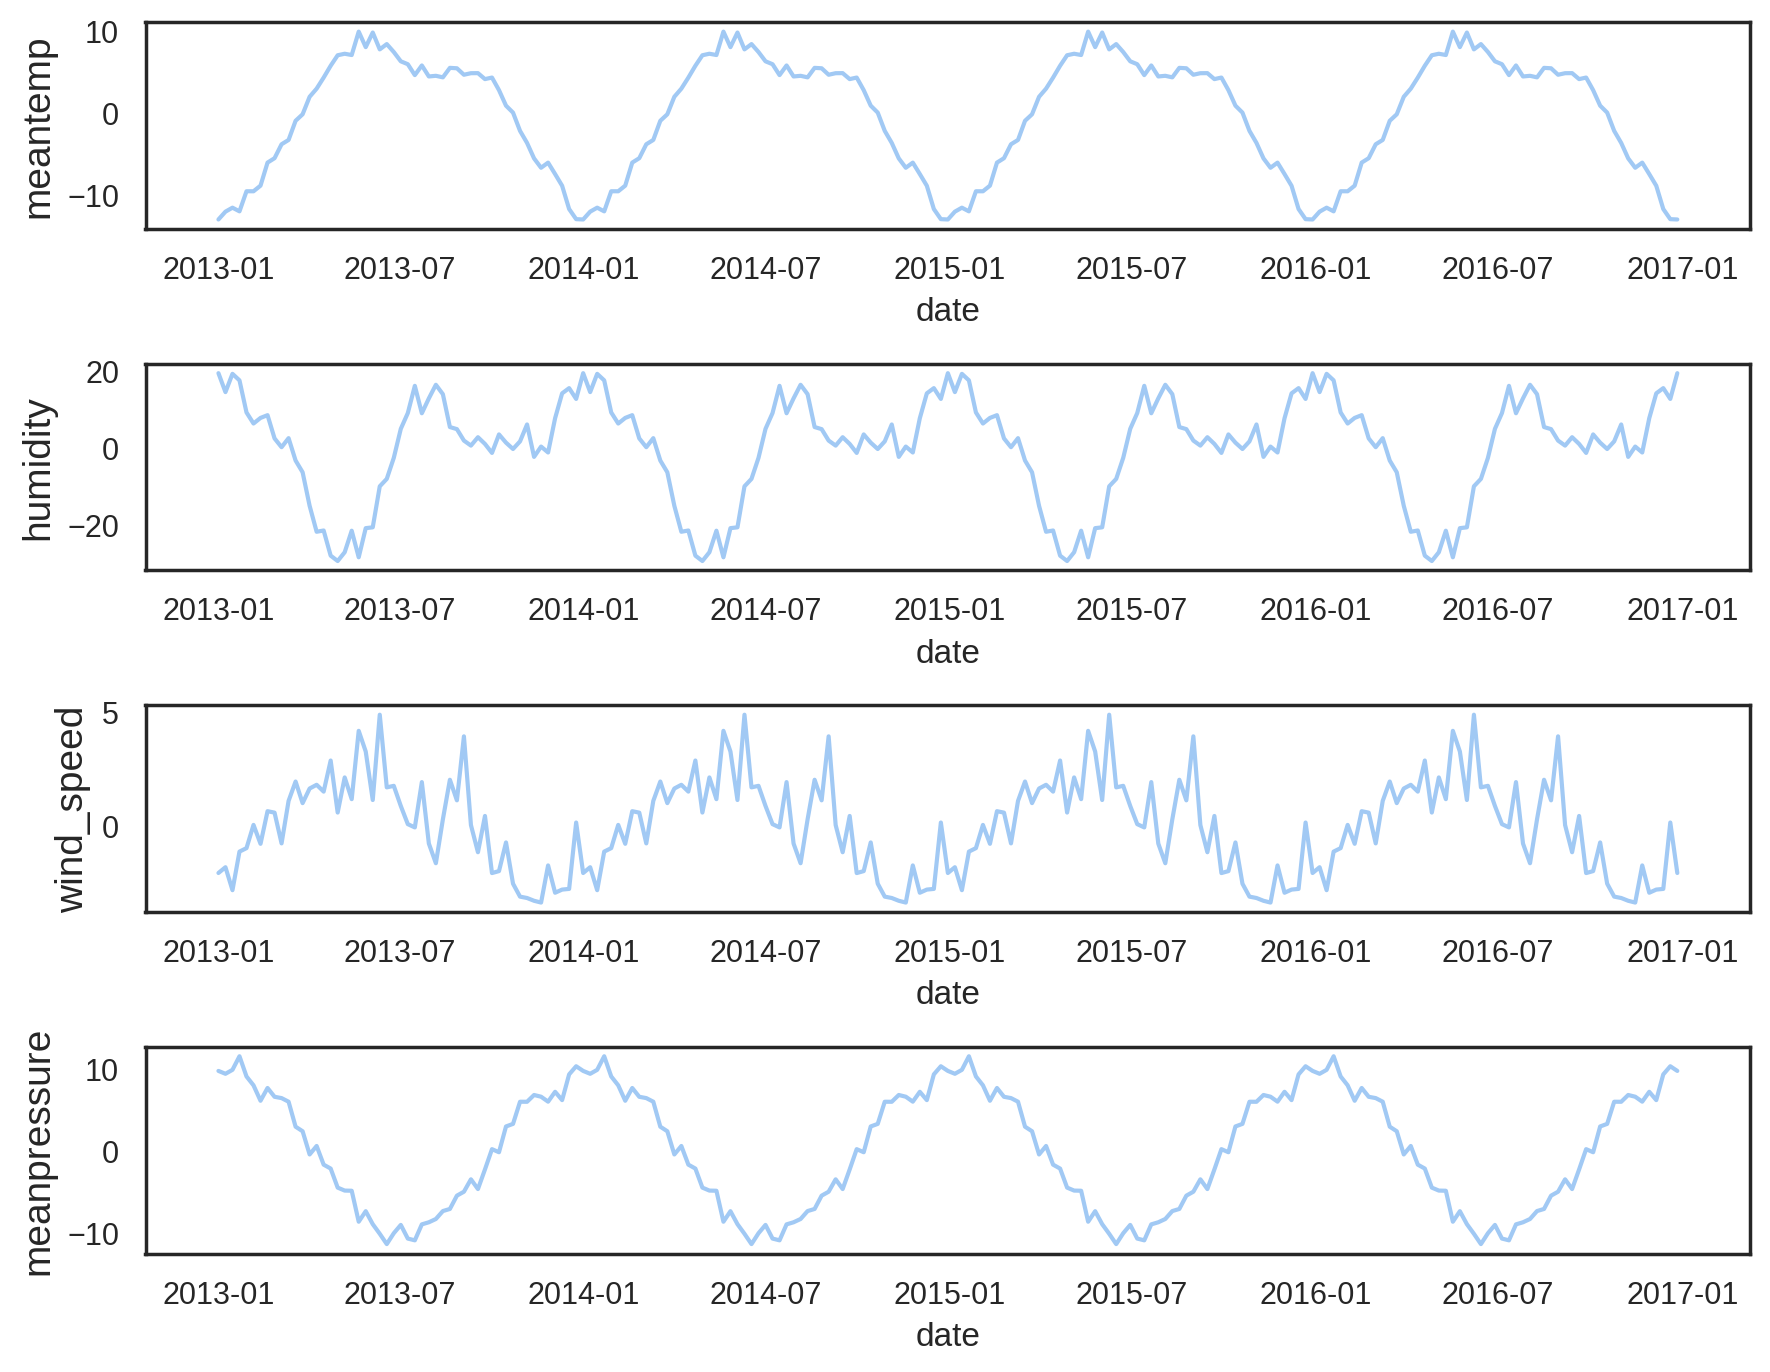

In [ ]:
# Plotting only seasonality for each column
for column in columns:
    decomp = seasonal_decompose(df[column], period=52, model='additive', extrapolate_trend='freq')
    df[f"{column}_trend"] = decomp.trend
    df[f"{column}_seasonal"] = decomp.seasonal
    
fig, ax =plt.subplots(nrows=4,ncols=1,figsize=(9,7))

for i, column in enumerate(columns):
    sns.lineplot(x=df['date'], y=df[column + '_seasonal'], ax=ax[i])
    ax[i].set_ylabel(ylabel=column, fontsize=14)
    
plt.tight_layout()

With rising temperatures and stronger winds, we can see a negative association between humidity and pressure. The weather patterns also seem to be consistent with the information given in the Weather in Delhi wikipedia article.

In order to further support the association between humidity, pressure, temperature, and wind speed, let's plot a correlation heatmap.


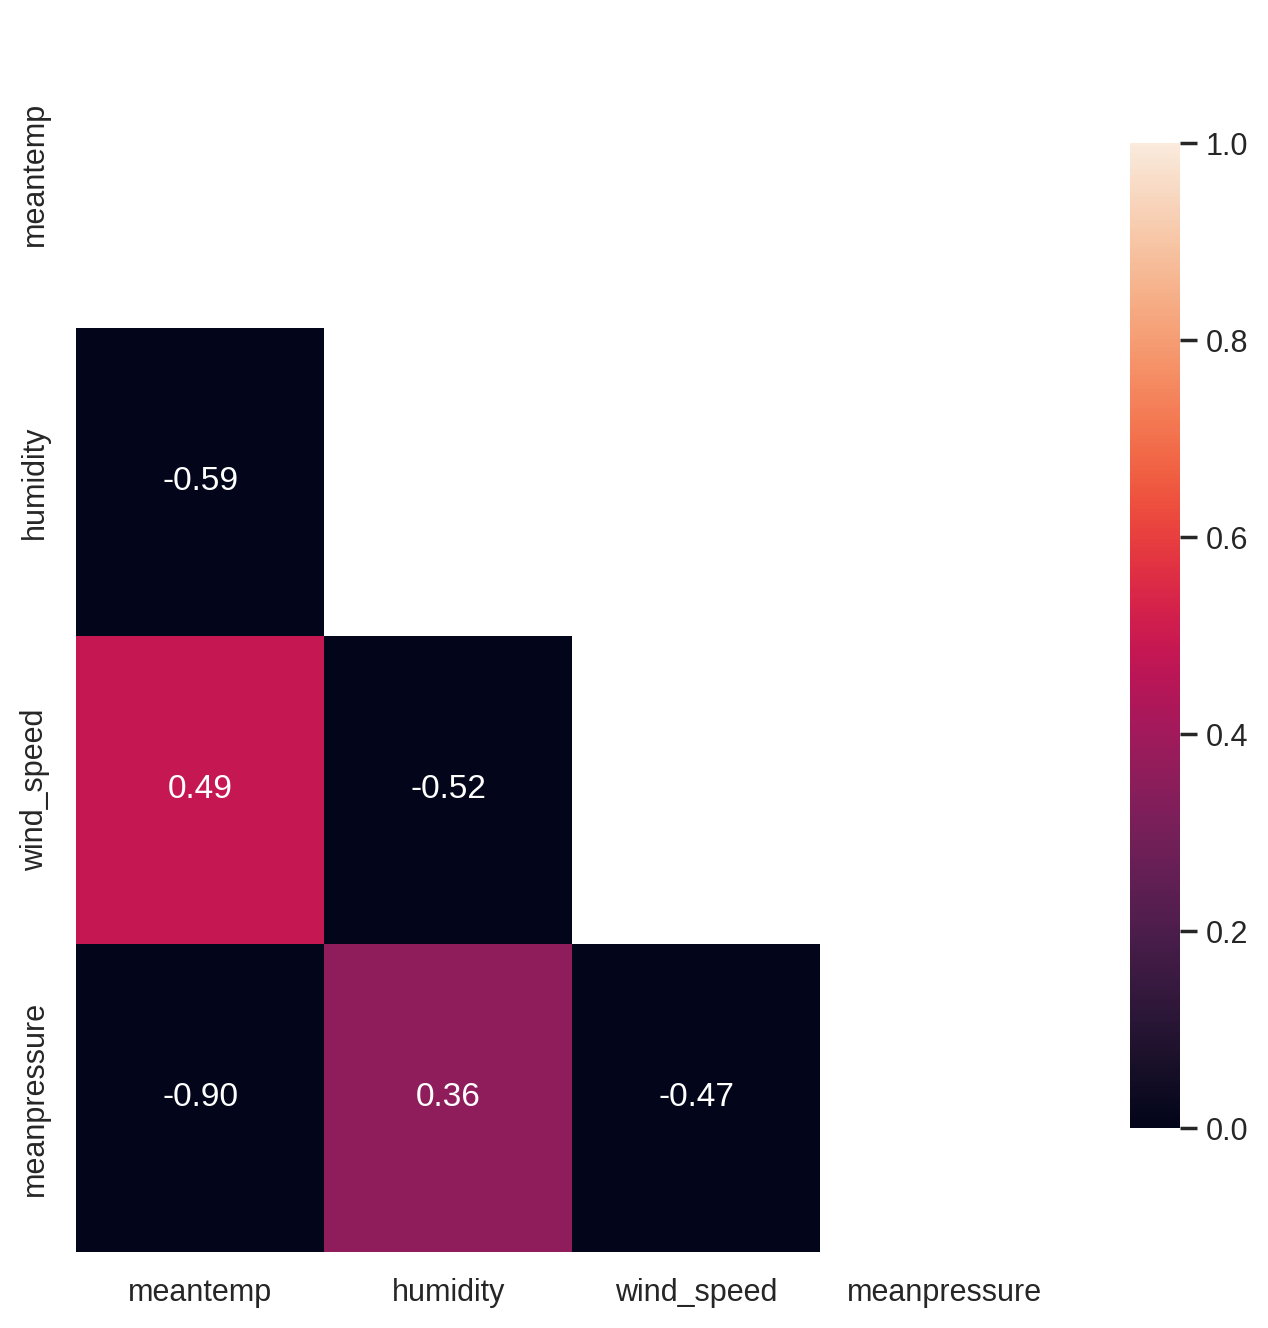

In [ ]:
# Plotting correlation heatmap of the dataset
corr=df[columns].corr()
mask= np.triu(np.ones_like(corr,dtype=np.bool))
fig,ax= plt.subplots(figsize=(8,8))
sns.heatmap(corr,mask=mask, annot=True, fmt=".2f",cbar_kws={"shrink": .8}, vmin=0, vmax=1)
None

For univariate time series forecasts, we'll employ the ARIMA model, and for multivariate time series forecasts, the Prophet model. Our goal is to forecast HUMIDITY over the upcoming 42 weeks.

In [ ]:
# Defining training dataset size (80%)
train_size = int(0.80 * len(df))

In [ ]:
# Defining univariate Dataframe - Target = humidity
univariate_df=df[['date', 'humidity']].copy()
univariate_df.columns = ['ds', 'y']

In [ ]:
# Train - Validation split
train = univariate_df.iloc[:train_size, :]

x_train, y_train = pd.DataFrame(univariate_df.iloc[:train_size, 0]), pd.DataFrame(univariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(univariate_df.iloc[train_size:, 0]), pd.DataFrame(univariate_df.iloc[train_size:, 1])

In [ ]:
# Tunning ARIMA model with AutoArima  
model = pm.auto_arima(y_train, start_p=0, start_q=0,
                      test='adf',       
                      max_p=3, max_q=3, 
                      m=1,              
                      d=None,           
                      seasonal=False,   
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1862.881, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1680.288, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1214.564, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1216.523, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1216.535, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1555.566, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1216.788, Time=0.14 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1203.370, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1290.447, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1205.773, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1204.422, Time=0.15 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1204.757, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1

In [ ]:
# Defining and fiting ARIMA model 
model = ARIMA(y_train, order=(2,0,0),trend='c')
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  167
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -597.389
Date:                Thu, 20 Apr 2023   AIC                           1202.778
Time:                        04:23:27   BIC                           1215.250
Sample:                             0   HQIC                          1207.840
                                - 167                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         62.5129      3.887     16.082      0.000      54.894      70.132
ar.L1          0.6645      0.076      8.790      0.000       0.516       0.813
ar.L2          0.1730      0.071      2.435      0.0

In [ ]:
# Prediction with ARIMA
y_pred = model_fit.forecast(42)

score_mae = mean_absolute_error(y_valid, y_pred)
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred))

print('RMSE: {}'.format(score_rmse))
print('MAE: {}'.format(score_mae))

RMSE: 16.679963753229853
MAE: 13.000169462571451


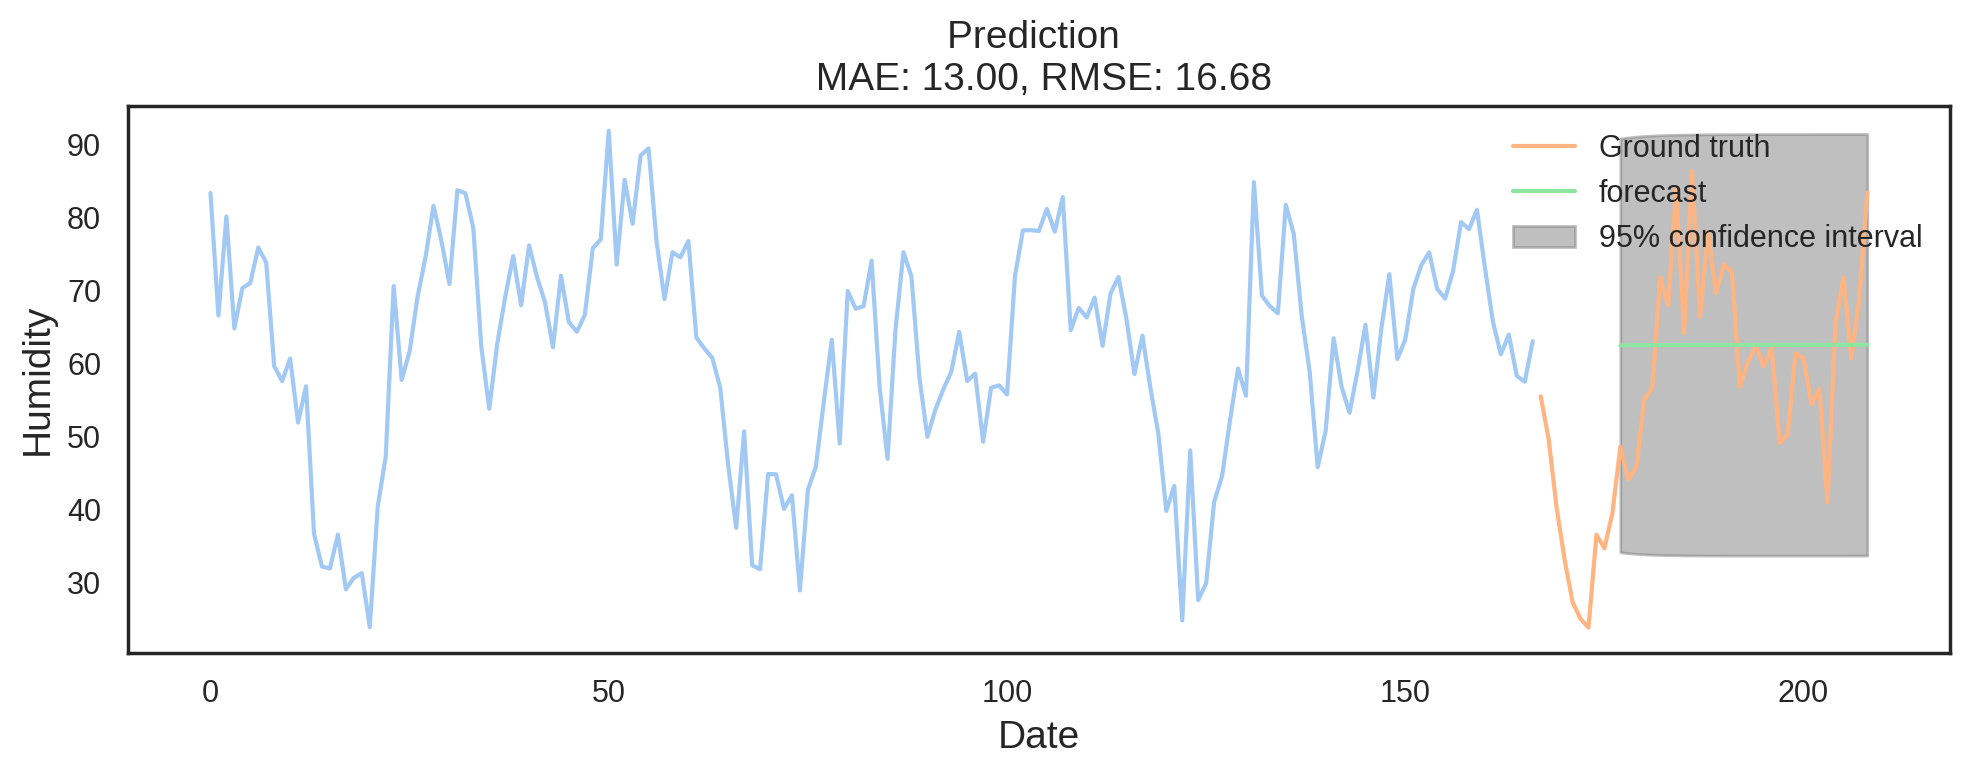

In [ ]:
# Plotting forecast - ARIMA univariate analysis 
fig, ax = plt.subplots(figsize=(10, 4))

sns.lineplot(x=x_train.index, y=y_train['y'], ax=ax)
sns.lineplot(x=x_valid.index, y=y_valid['y'], ax=ax, label='Ground truth') 
plot_predict(model_fit,177, 208, ax=ax)

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Humidity', fontsize=14)

plt.tight_layout()

On observing the above model, it is easily visualizable that it has enormous RMSE ansd MAE. In order to minimize it, we will predict using Prophet model - a method for forecasting time series data based on an additive model where non-linear trends are fit with yearly, monthly, weekly, and daily seasonality.

Multivariate time series forecasts using Prophet (BEST in working with time series which have strong seasonal effects)

In [ ]:
# Defining multivariate Dataframe - Target = humidity
features= ['meantemp',
          'wind_speed',
          'meanpressure']

target=['humidity']

multivariate_df= df[['date'] + target + features].copy()
multivariate_df.columns = ['ds', 'y'] + features

multivariate_df.head(5).append(multivariate_df.tail(5))

,ds,y,meantemp,wind_speed,meanpressure
0,2013-01-01,83.295238,7.604762,2.903810,1017.685714
1,2013-01-08,66.511905,13.176871,8.013265,1015.942177
2,2013-01-15,80.068027,13.409524,4.471905,1017.972789
3,2013-01-22,64.748299,12.848639,4.981973,1019.884694
4,2013-01-29,70.279592,16.107653,3.396378,1016.554592
204,2016-11-29,65.384536,19.883387,4.234881,1017.473212
205,2016-12-06,71.711197,18.500047,2.837198,1015.210392
206,2016-12-13,60.698526,17.578005,6.974330,1017.191007
207,2016-12-20,69.026283,17.020965,9.403279,1014.833210
208,2016-12-27,83.352881,14.742226,5.245749,1016.612457


In [ ]:
# Train - Validation split
train = multivariate_df.iloc[:train_size, :]
x_train, y_train = pd.DataFrame(multivariate_df.iloc[:train_size, [0,2,3,4]]), pd.DataFrame(multivariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(multivariate_df.iloc[train_size:, [0,2,3,4]]), pd.DataFrame(multivariate_df.iloc[train_size:, 1])

In [ ]:
# Train the model
model = Prophet()
model.add_regressor('meantemp')
model.add_regressor('wind_speed')
model.add_regressor('meanpressure')

# Fit the model with train set
model.fit(train)

# Predict on valid set
y_pred = model.predict(x_valid)

# Calcuate metrics
score_mae = mean_absolute_error(y_valid, y_pred['yhat'])
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred['yhat']))

print('RMSE: {}'.format(score_rmse))
print('MAE: {}'.format(score_mae))

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm_k1uib6/e0jd_yd7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm_k1uib6/jl3sxax3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75471', 'data', 'file=/tmp/tmpm_k1uib6/e0jd_yd7.json', 'init=/tmp/tmpm_k1uib6/jl3sxax3.json', 'output', 'file=/tmp/tmpm_k1uib6/prophet_modeljipp82o4/prophet_model-20230420042508.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:25:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:25:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


RMSE: 6.515806291157756
MAE: 5.387056250448283


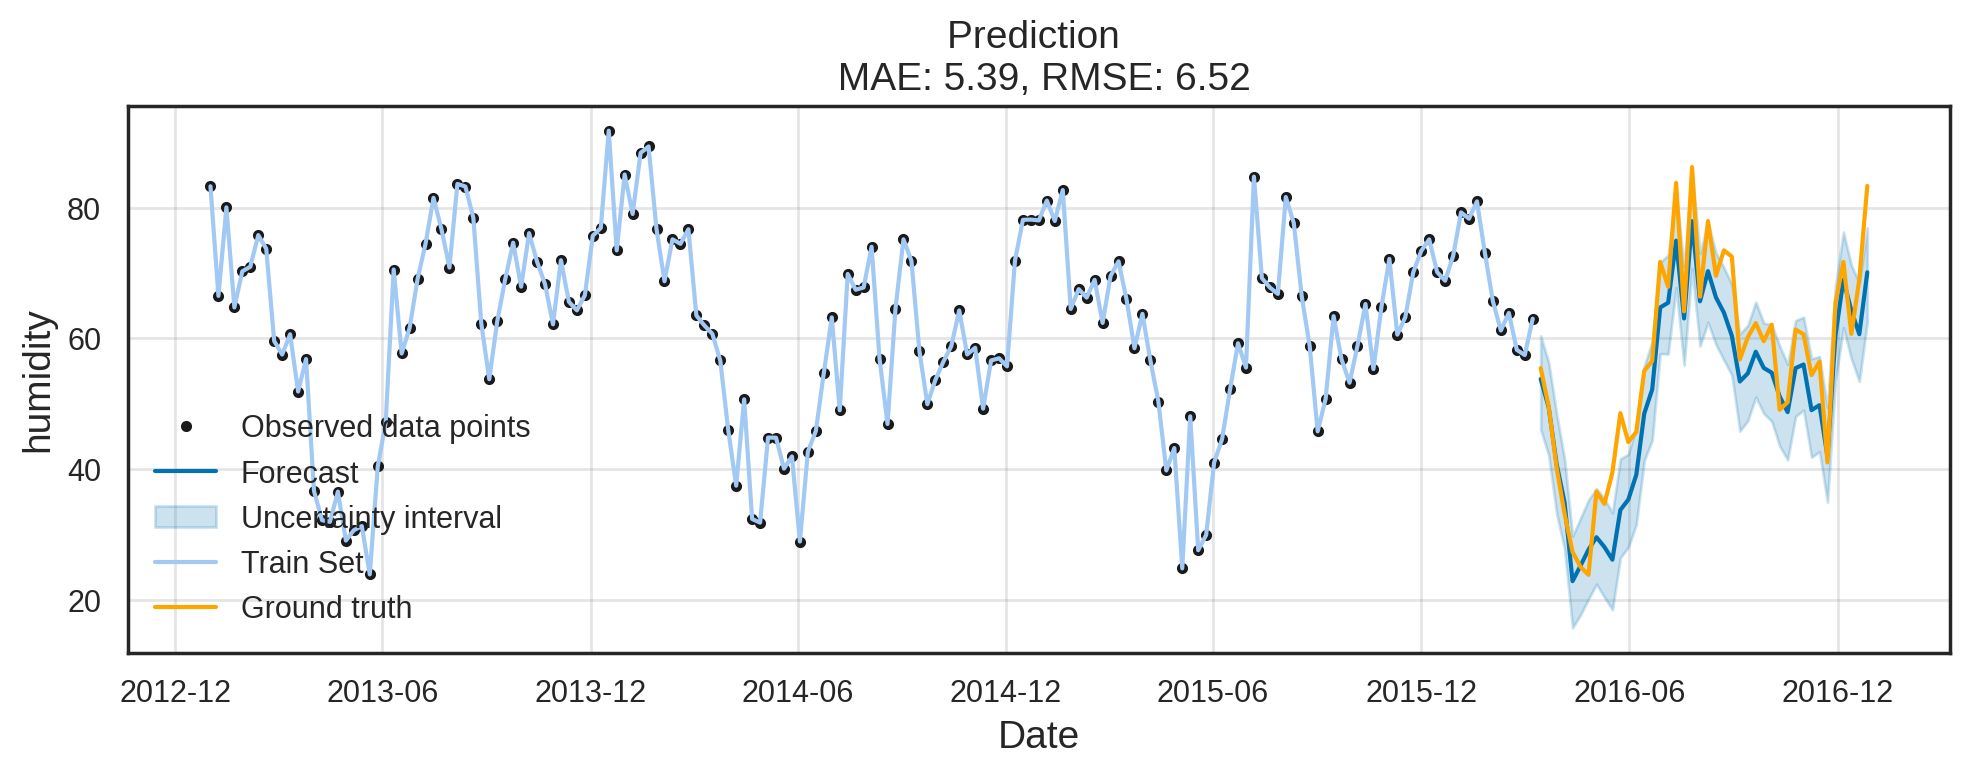

In [ ]:
# Plotting forecast - Prophet multivariate analysis 
fig, ax = plt.subplots(figsize=(10, 4))

model.plot(y_pred, ax=ax)
sns.lineplot(x=x_train['ds'], y=y_train['y'], ax=ax, label='Train Set')
sns.lineplot(x=x_valid['ds'], y=y_valid['y'], ax=ax, color='orange', label='Ground truth')

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='humidity', fontsize=14)

plt.tight_layout()

We obtained better result in Prophet model then Arena model. 

Now lets predict mean Temperature using the same Prophet model.

In [ ]:
# Defining multivariate Dataframe - Target = meantemp
features= ['wind_speed','meanpressure','humidity']

target=['meantemp']

multivariate_df= df[['date'] + target + features].copy()
multivariate_df.columns = ['ds', 'y'] + features

multivariate_df.head(5).append(multivariate_df.tail(5))

,ds,y,wind_speed,meanpressure,humidity
0,2013-01-01,7.604762,2.903810,1017.685714,83.295238
1,2013-01-08,13.176871,8.013265,1015.942177,66.511905
2,2013-01-15,13.409524,4.471905,1017.972789,80.068027
3,2013-01-22,12.848639,4.981973,1019.884694,64.748299
4,2013-01-29,16.107653,3.396378,1016.554592,70.279592
204,2016-11-29,19.883387,4.234881,1017.473212,65.384536
205,2016-12-06,18.500047,2.837198,1015.210392,71.711197
206,2016-12-13,17.578005,6.974330,1017.191007,60.698526
207,2016-12-20,17.020965,9.403279,1014.833210,69.026283
208,2016-12-27,14.742226,5.245749,1016.612457,83.352881


In [ ]:
# Train - Validation split
train = multivariate_df.iloc[:train_size, :]
x_train, y_train = pd.DataFrame(multivariate_df.iloc[:train_size, [0,2,3,4]]), pd.DataFrame(multivariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(multivariate_df.iloc[train_size:, [0,2,3,4]]), pd.DataFrame(multivariate_df.iloc[train_size:, 1])

In [ ]:
# Train the model
model = Prophet()
model.add_regressor('humidity')
model.add_regressor('wind_speed')
model.add_regressor('meanpressure')

# Fit the model with train set
model.fit(train)

# Predict on valid set
y_pred = model.predict(x_valid)

# Calcuate metrics
score_mae = mean_absolute_error(y_valid, y_pred['yhat'])
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred['yhat']))

print('RMSE: {}'.format(score_rmse))
print('MAE: {}'.format(score_mae))

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm_k1uib6/4h4q5b78.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm_k1uib6/itb_m9p0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94835', 'data', 'file=/tmp/tmpm_k1uib6/4h4q5b78.json', 'init=/tmp/tmpm_k1uib6/itb_m9p0.json', 'output', 'file=/tmp/tmpm_k1uib6/prophet_model23n7mq0e/prophet_model-20230420042927.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:29:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:29:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


RMSE: 0.9733868889178319
MAE: 0.8132169409772878


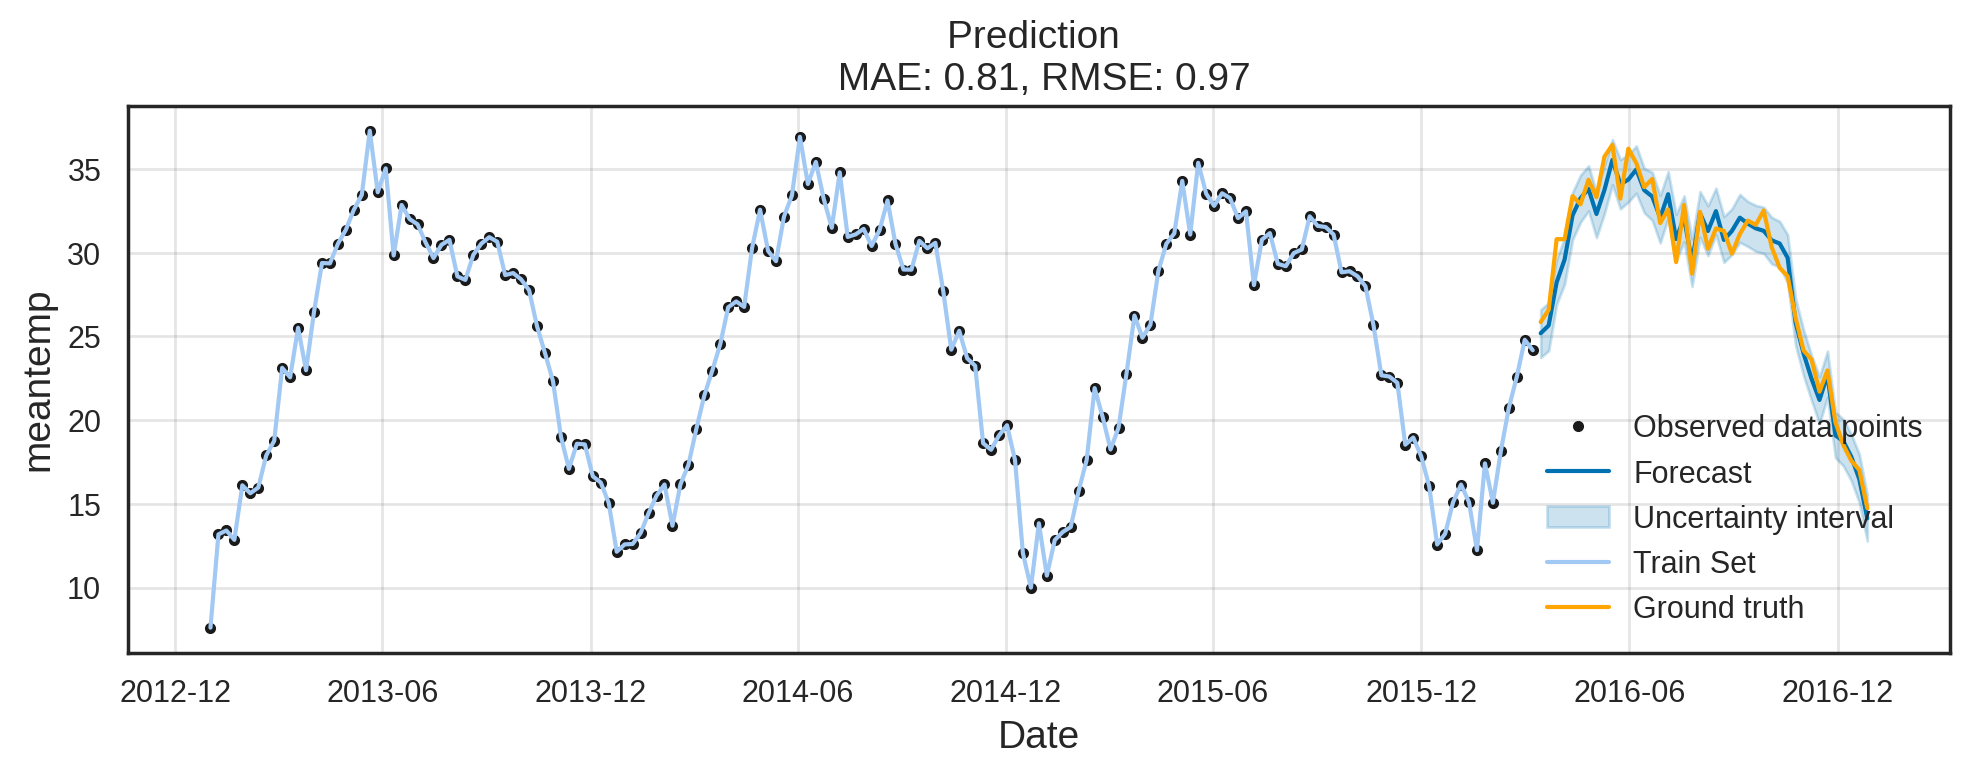

In [ ]:
# Plotting forecast - Prophet multivariate analysis 
fig, ax = plt.subplots(figsize=(10, 4))

model.plot(y_pred, ax=ax)
sns.lineplot(x=x_train['ds'], y=y_train['y'], ax=ax, label='Train Set')
sns.lineplot(x=x_valid['ds'], y=y_valid['y'], ax=ax, color='orange', label='Ground truth')

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='meantemp', fontsize=14)

plt.tight_layout()